# Focal Plane Poster Images

In [1]:
%matplotlib inline

In [38]:
import os
import sys
import io
from pathlib import Path

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [74]:
from PIL import Image, ImageChops

In [5]:
import fitsio

In [6]:
import fpoffline.fvc
import fpoffline.const

In [7]:
import requests

In [8]:
sys.path.insert(0, '/global/homes/d/dkirkby/DESI/code/desimeter/py')
import desimeter
print(desimeter.__file__)

/global/homes/d/dkirkby/DESI/code/desimeter/py/desimeter/__init__.py


In [9]:
import desimeter.transform.xy2qs
import desimeter.processfvc

In [10]:
DESI = Path('/global/cfs/cdirs/desi')
DATA = DESI /  'spectro' / 'data'
assert DATA.exists()

In [11]:
SCRATCH = Path(os.getenv('SCRATCH'))
assert SCRATCH.exists()

## Focal Plane

Use the stack of 100 x 10s front-illuminated FVC images taken 20220113 (details [here](https://desi.lbl.gov/trac/wiki/FPS/FrontIlluminatedImage)).  These are interesting for a poster since the robots are not parked.

In [12]:
def stack_fvc(path, expids, ext='F0000', verbose=True):
    path = Path(path)
    if not path.exists():
        raise ValueError('Invalid path: {path}')
    stack = np.zeros((6000,6000), np.float32)
    tot_exptime = 0
    for expid in expids:
        exptag = str(expid).zfill(8)
        filename = path / exptag / f'fvc-{exptag}.fits.fz'
        if not filename.exists():
            raise ValueError('Missing file: {filename}')
        hdr = fitsio.read_header(str(filename), ext=ext)
        tot_exptime += hdr.get('EXPTIME', 0)
        data = fitsio.read(str(filename), ext=ext)
        stack += data
    if verbose:
        print(f'Stacked {tot_exptime:.1f}s from {len(expids)} exposures.')
    return stack

In [13]:
front_illuminated = fpoffline.fvc.process_front_illuminated(stack_fvc(DATA / '20220113', range(118532, 118632)))

Stacked 1000.0s from 100 exposures.


Combine two matching back-illuminated FVC images to superimpose spots:

In [14]:
back_illuminated_raw = stack_fvc(DATA / '20220113', [118530, 118633])

Stacked 4.0s from 2 exposures.


In [15]:
import scipy.stats

In [16]:
def process_back_illuminated(D, nsig=4, scale=1000):
    """Perform bias & dark currrent subtraction then apply an arcsinh
    stretch and clip any low tail. The result has min=-1 and mean~0.
    """
    D = fpoffline.fvc.measure_subtract_bias(D, plot=False)
    clipped, _, _ = scipy.stats.sigmaclip(D, nsig, nsig)
    mu, sig = clipped.mean(), clipped.std()
    return np.arcsinh(np.clip((D - mu) / scale, 0, None))

In [17]:
back_illuminated = process_back_illuminated(back_illuminated_raw)

Calculate the radial distance of the outer GIF (DEVICE_LOC 542) from the nominal petal design:

In [18]:
DESIGN = fpoffline.const.get_petal_design()
idx = DESIGN.locmap[542]
r542 = np.hypot(DESIGN.xfp[3, idx], DESIGN.yfp[3, idx])
print(f'r542 = {r542:.3f} mm')

r542 = 410.717 mm


Convert to the distance along the curved focal surface, since the FVC image effectively flattens out this curvature:

In [19]:
s542 = desimeter.transform.xy2qs.r2s(r542)
print(f's542 = {s542:.3f} mm')

s542 = 411.316 mm


Use desimeter to locate the back-illuminated spots:

In [20]:
exptag = str(118633).zfill(8)
back_fits = DATA / '20220113' / exptag / f'fvc-{exptag}.fits.fz'
spots = desimeter.processfvc.process_fvc(str(back_fits), use_subprocess=False).to_pandas()

INFO:processfvc.py:127:get_spots_list:read FITS FVC image
INFO:processfvc.py:150:get_spots_list:reading image in extension F0000



  file: /global/cfs/cdirs/desi/spectro/data/20220113/00118633/fvc-00118633.fits.fz
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       FVC
  1      IMAGE_HDU       F0000


INFO:detectspots.py:142:detectspots:gaussian convolve with sigma = 1.0 pixels
INFO:detectspots.py:158:detectspots:convolved image pedestal=988.04 rms=37.40
INFO:detectspots.py:185:detectspots:found 5460 peaks
INFO:detectspots.py:210:detectspots:fvc image pedestal=-0.33 rms=39.27
INFO:findfiducials.py:28:findfiducials:loading input tranform from /global/homes/d/dkirkby/DESI/code/desimeter/py/desimeter/data/init-fvc2fp.json
INFO:findfiducials.py:36:findfiducials:with pixel2fp = 0.149 mm, pinhole max separation = 10.038 pixels 
INFO:findfiducials.py:60:findfiducials:select spots with at least two close neighbors (in pixel units)
INFO:findfiducials.py:71:findfiducials:first match 121 fiducials candidates to metrology (118) with iterative fit
INFO:findfiducials.py:87:findfiducials:iter #0 median_dist=97.18231051785902 max_dist=408.1657041750078 matches=103
INFO:findfiducials.py:87:findfiducials:iter #1 median_dist=22.61676759237013 max_dist=94.99042388795453 matches=112
INFO:findfiducials.p

wrote /tmp/fvc-00118633.csv


In [21]:
spots542 = spots[spots.DEVICE_LOC == 542].groupby('PETAL_LOC').mean()

In [22]:
np.hypot(spots542.X_FP, spots542.Y_FP)

PETAL_LOC
0    410.670303
1    410.296247
2    410.600893
3    410.225274
4    410.647946
5    410.186937
6    410.300003
7    410.598075
8    410.839732
9    410.775587
dtype: float64

Calculate the median separation in FVC pixels between GIFs on opposite petals:

In [23]:
diam542fvc = np.median([
    np.hypot(spots542.loc[k].XPIX - spots542.loc[k+5].XPIX, spots542.loc[k].YPIX - spots542.loc[k+5].YPIX)
    for k in range(5)
])
print(f'diam542fvc = {diam542fvc:.1f} pix')

diam542fvc = 5630.1 pix


Calculate the DPI value that correctly scales the FVC image to flattened distance:

In [24]:
dpi = diam542fvc / (2 * s542 / 25.4)
print(f'DPI = {dpi:.1f}')

DPI = 173.8


Estimate the coords of the focal-plane origin in FVC pixels:

In [25]:
x0, y0 = np.round(np.mean([
    ((spots542.loc[k].XPIX + spots542.loc[k+5].XPIX) / 2, (spots542.loc[k].YPIX + spots542.loc[k+5].YPIX) / 2)
    for k in range(5)
], axis=0)).astype(int)
(x0, y0)

(3003, 2972)

Tint the back-illuminated spots cyan:

In [26]:
data = back_illuminated
back_illuminated_tinted = np.array((0,1,1)).reshape(1, 1, 3) * (np.expand_dims(data,-1) - data.min()) / (data.max() - data.min())

Apply a colormap stretch to the (grayscale) front-illuminated image:

In [27]:
cmap = plt.get_cmap('cividis')
front_illuminated_stretch = cmap(front_illuminated)[:,:,:3]

Superimpose the tinted spots on the front-illuminated image:

In [28]:
combined = np.clip(front_illuminated_stretch + back_illuminated_tinted, 0, 1)

Center the image on the FP origin and clip to be square:

In [29]:
def center(s):
    if s > 3000:
        half = 6000 - s
        return slice(s - half, 6000)
    else:
        half = s
        return slice(0, s + half)

In [108]:
xslice = center(x0)
yslice = center(y0)
print(xslice, yslice)
centered = combined[yslice, xslice]
print(centered.shape)

slice(6, 6000, None) slice(0, 5944, None)
(5944, 5994, 3)


Visual check that we are centered:

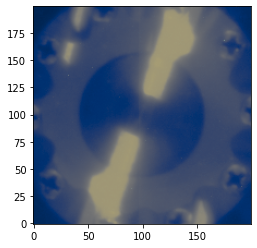

In [109]:
ny, nx, _ = centered.shape
size = 100
plt.imshow(centered[ny//2-size:ny//2+size, nx//2-size:nx//2+size], origin='lower');

Save the combined image as a (large) uncompressed PNG with the DPI value calculated above:

In [62]:
def save_fvc(data=centered, save='poster.png'):
    """Plot an FVC image at full size (6000,6000) in the usual orientation.
    """
    h, w, _ = data.shape
    fig = plt.figure(figsize=(w / dpi, h / dpi), dpi=dpi, frameon=False)
    ax = plt.axes((0, 0, 1, 1))
    ax.imshow(data[:,::-1], origin='lower', interpolation='none')
    ax.axis('off')
    plt.savefig(save, dpi=dpi)
    plt.close(fig)
    
save_fvc()

## NeoWISE Background Image

Generate a sky background image that is scaled to the focal plane according to the DESI optics and the full width of the poster.

In [32]:
# average ECHO22 platescale in microns/arcsec
platescale = 70.54

In [55]:
def get_tanproj(ra, dec, fov, size, layer='unwise-neo6'):
    pixscale = fov * 3600 / size
    url = f'https://www.legacysurvey.org/viewer/cutout.jpg?ra={ra}&dec={dec}&layer={layer}&pixscale={pixscale}&size={size}'
    r = requests.get(url)
    return Image.open(io.BytesIO(r.content))

Get a NeoWISE6 background image centered on RA=120 DEC=20 which is within the DESI footprint and on the ecliptic. We need over 6K pixels on a side but the legasurvey cutout viewer only allows up to 2K requests, so we need to fetch and assemble a sequence of tiles.

In [188]:
def get_background(RA0=120, DEC0=20, width_inch=36, height_inch=38, max_tilesize=2000):
    
    inch2deg = lambda inch: inch * 25400 / platescale / 3600
    
    # Calculate the number of pixels corresponding to the requested printed dimensions.
    width_pixel = round(width_inch * round(dpi))
    height_pixel = round(height_inch * round(dpi))
    data = np.zeros((height_pixel, width_pixel, 3), np.uint8)

    print(f'size = {width_inch} x {height_inch} inch = {width_pixel} x {height_pixel} pixels')
    
    def get_offsets(size):
        ntile = int(np.ceil(size / max_tilesize))
        step = round(size / ntile)
        offset_pixel = np.arange(ntile + 1) * step
        assert offset_pixel[-1] == size
        centers = 0.5 * (offset_pixel[1:] + offset_pixel[:-1])
        offset_deg = inch2deg((0.5 * size - centers) / round(dpi))
        return offset_pixel, offset_deg
        
    xoffsets, dRA = get_offsets(width_pixel)
    yoffsets, dDEC = get_offsets(height_pixel)
    dRA /= np.cos(np.deg2rad(DEC0))
    
    for ix in range(len(dRA)):
        xlo, xhi = xoffsets[ix:ix+2]
        xsize_pixel = xhi - xlo
        for iy in range(len(dDEC)):
            ylo, yhi = yoffsets[iy:iy+2]
            ysize_pixel = yhi - ylo
            # Cutout service returns square images so round up then trim.
            size_pixel = max(xsize_pixel, ysize_pixel)
            fov_inch = size_pixel / round(dpi)
            fov_deg = inch2deg(fov_inch)
            print(f'tile[{ix},{iy}] fov={fov_deg:.3f}deg dRA={dRA[ix]:.3f}deg dDEC={dDEC[iy]:.3f}deg')
            img_data = np.array(get_tanproj(ra=RA0+dRA[ix], dec=DEC0+dDEC[iy], fov=fov_deg, size=size_pixel))
            smaller = min(xsize_pixel, ysize_pixel)
            inset = (size_pixel - smaller) // 2
            inset_slice = slice(inset, inset + smaller)
            if xsize_pixel > ysize_pixel:
                img_data = img_data[inset_slice, :]
            else:
                img_data = img_data[:, inset_slice]
            data[ylo:yhi,xlo:xhi] = img_data

    img = Image.fromarray(data)
    img.save('background.png')

get_background()

size = 36 x 38 inch = 6264 x 6612 pixels
tile[0,0] fov=0.950deg dRA=1.437deg dDEC=1.425deg
tile[0,1] fov=0.950deg dRA=1.437deg dDEC=0.475deg
tile[0,2] fov=0.950deg dRA=1.437deg dDEC=-0.475deg
tile[0,3] fov=0.950deg dRA=1.437deg dDEC=-1.425deg
tile[1,0] fov=0.950deg dRA=0.479deg dDEC=1.425deg
tile[1,1] fov=0.950deg dRA=0.479deg dDEC=0.475deg
tile[1,2] fov=0.950deg dRA=0.479deg dDEC=-0.475deg
tile[1,3] fov=0.950deg dRA=0.479deg dDEC=-1.425deg
tile[2,0] fov=0.950deg dRA=-0.479deg dDEC=1.425deg
tile[2,1] fov=0.950deg dRA=-0.479deg dDEC=0.475deg
tile[2,2] fov=0.950deg dRA=-0.479deg dDEC=-0.475deg
tile[2,3] fov=0.950deg dRA=-0.479deg dDEC=-1.425deg
tile[3,0] fov=0.950deg dRA=-1.437deg dDEC=1.425deg
tile[3,1] fov=0.950deg dRA=-1.437deg dDEC=0.475deg
tile[3,2] fov=0.950deg dRA=-1.437deg dDEC=-0.475deg
tile[3,3] fov=0.950deg dRA=-1.437deg dDEC=-1.425deg


## Moon Image

In [89]:
moonURL = 'https://svs.gsfc.nasa.gov/vis/a000000/a004900/a004955/frames/730x730_1x1_30p/moon.2328.jpg'

In [99]:
def get_image(name, URL):
    if not name.exists():
        with requests.get(URL, stream=True) as r:
            r.raise_for_status()
            print('downloading...', end='')
            with open(name, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
                    print('.', end='')
        print('done')
    img = Image.open(name)
    print(f'Loaded dims: {img.width} x {img.height}')
    # Trim out background
    bg = Image.new(img.mode, img.size, img.getpixel((0,0)))
    diff = ImageChops.difference(img, bg)
    diff = ImageChops.add(diff, diff, 2.0, -4)
    bbox = diff.getbbox()
    img = img.crop(bbox)
    print(f'Cropped dims: {img.width} x {img.height}')
    return img

In [100]:
moon = get_image(SCRATCH / 'moon-image.png', moonURL)

Loaded dims: 730 x 730
Cropped dims: 621 x 622


In [106]:
def get_moon(diam_arcmin=31.0):
    
    diam_inch = diam_arcmin * 60 * platescale / 25400
    diam_pixel = round(diam_inch * round(dpi))
    
    print(f'moon diameter = {diam_inch:.2f} inch = {diam_pixel} pix')
    
    resized = moon.resize((diam_pixel, diam_pixel))
    resized.save('moon.png', dpi=(round(dpi), round(dpi)))
    
get_moon()

moon diameter = 5.17 inch = 899 pix


# QR Code

Generate a QR code that links to an outreach page with details on the poster.

In [110]:
qrURL = 'https://data.desi.lbl.gov/public/epo/desifp/'

In [183]:
try:
    import qrcode
    import qrcode.constants
    import qrcode.image.styledpil
    import qrcode.image.svg
    from qrcode.image.styles.moduledrawers import CircleModuleDrawer
    qr = qrcode.QRCode(version=1, box_size=15, border=2, error_correction=qrcode.constants.ERROR_CORRECT_Q,
                       #image_factory=qrcode.image.styledpil.StyledPilImage)
                       image_factory=qrcode.image.svg.SvgPathImage)
    qr.add_data(qrURL)
    qr.make(fit=True)
    img = qr.make_image(back_color='black', fill_color='white', module_drawer=CircleModuleDrawer())
    img.save('qrcode.svg')
    
except ImportError as e:
    print(e)
    print('You need to install the qrcode package')